In [1]:
# Scientific libraries
import scipy
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import pandas as pd

# Graphic libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
# import japanize_matplotlib
import seaborn as sns
# import holoviews as hv
# from bokeh.io import output_notebook
# output_notebook()
# from bokeh.io import show
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
# from ipywidgets import interact # Interactive graph

# Statistical libraries
# import statsmodels.stats as stats
# import statsmodels.stats.multicomp as multi
# import statsmodels.formula.api as smf
# import scikit_posthocs as sp

# Other libraries
# import re
# from datetime import datetime
# import collections

# Creating alias for magic commands
%alias_magic t time

from icecream import ic

import requests
import zipfile
import math
from scipy.stats import poisson
import os.path

rcParams['font.size'] = 12
rcParams['figure.figsize'] = (6, 6)

Created `%t` as an alias for `%time`.
Created `%%t` as an alias for `%%time`.


In [2]:
# 著者サイトからdata3a.csvをダウンロード
response = requests.get('https://kuboweb.github.io/-kubo/stat/iwanamibook/fig/poisson/data3a.csv')
file_name = "data3a.csv"

if not os.path.exists(file_name):
    with open (file_name, 'wb') as f:
        f.write(response.content)
        f.close()
data = pd.read_csv(file_name)

data["d"] = (data["f"] == "T")*1
data

,y,x,f,d
0,6,8.31,C,0
1,6,9.44,C,0
2,6,9.50,C,0
3,12,9.07,C,0
4,10,10.16,C,0
...,...,...,...,...
95,8,9.15,T,1
96,6,8.52,T,1
97,8,10.24,T,1
98,7,10.86,T,1


$$
\begin{align}
  x &\stackrel{\text{def}}{=} \text{体サイズ} \\
  y &\stackrel{\text{def}}{=} \text{種子数} \\
  f &\stackrel{\text{def}}{=} \text{施肥の有無} \\
\end{align}
$$

In [3]:
display(data.describe(include="all"))
display(data.value_counts("f"))

print("variance:")
display(data.var())

print("standard error:")
display(data.sem())

,y,x,f,d
count,100.000000,100.000000,100,100.000000
unique,NaN,NaN,2,NaN
top,NaN,NaN,T,NaN
freq,NaN,NaN,50,NaN
mean,7.830000,10.089100,NaN,0.500000
std,2.624881,1.008049,NaN,0.502519
min,2.000000,7.190000,NaN,0.000000
25%,6.000000,9.427500,NaN,0.000000
50%,8.000000,10.155000,NaN,0.500000
75%,10.000000,10.685000,NaN,1.000000


f
T    50
C    50
dtype: int64

variance:


y    6.890000
x    1.016162
d    0.252525
dtype: float64

standard error:


y    0.262488
x    0.100805
d    0.050252
dtype: float64

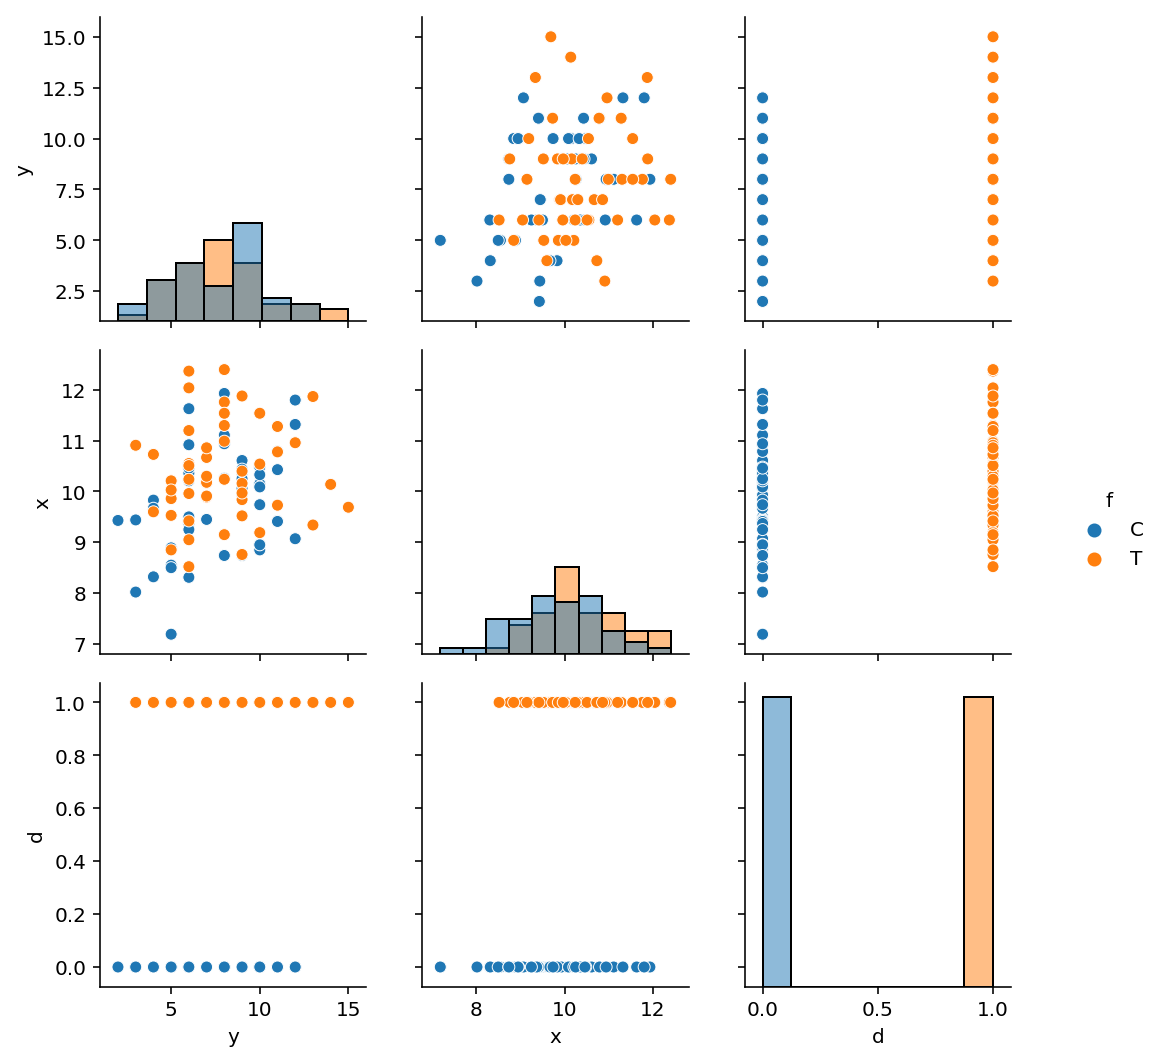

In [4]:
sns.pairplot(data=data,
             hue="f",
             diag_kind="hist")
plt.show()

In [5]:
params = {}

# in R;
# $ fit <- glm(y ~ x, data=d, family=poisson)
# $ print(fit)

params["x model"] = {}

x_model_fitted = sm.GLM(data["y"], # 応答変数
                        sm.add_constant(data["x"]), # 切片つき説明変数, 複数列も可
                        family=sm.families.Poisson() # 分布の指定
                       ).fit()

display(x_model_fitted.summary())

params["x model"]["b_1"] = x_model_fitted.params["const"]
params["x model"]["b_2"] = x_model_fitted.params["x"]
params["x model"]["log-likelihood"] = x_model_fitted.llf
params["x model"]["D"] = -2*x_model_fitted.llf
params["x model"]["resid.D"] = x_model_fitted.deviance
params["x model"]["null.D"] = x_model_fitted.null_deviance
params["x model"]["AIC"] = x_model_fitted.aic

print("Deviance: {}".format(params["x model"]["D"]))
print("Residual Deviance: {}".format(params["x model"]["resid.D"]))
print("Min. Deviance: {}".format(params["x model"]["D"] \
                                 - params["x model"]["resid.D"]))
print("Max. Deviance: {}".format(params["x model"]["D"] \
                                 - params["x model"]["resid.D"] \
                                 + params["x model"]["null.D"]))

print("AIC: {}".format(x_model_fitted.aic))
# print("BIC: {}".format(x_model_fitted.bic))

print()
mlh_full = sum([poisson.logpmf(y_i, y_i) for y_i in data["y"]])
print("Maximum Likelihood of Full model: {}".format(mlh_full))
print("Min. of Deviance: {}".format(-2*mlh_full))

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -235.39
Date:                Tue, 02 Feb 2021   Deviance:                       84.993
Time:                        17:55:32   Pearson chi2:                     83.8
No. Iterations:                     4   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2917      0.364      3.552      0.000       0.579       2.005
x              0.0757      0.036      2.125      0.034       0.006       0.145
==============================================================================
"""

Deviance: 470.7725015397216
Residual Deviance: 84.9929964907296
Min. Deviance: 385.779505048992
Max. Deviance: 475.2864426185734
AIC: 474.7725015397216

Maximum Likelihood of Full model: -192.8897525244958
Min. of Deviance: 385.7795050489916


In [6]:
params["null model"] = {}

null_model_fitted = sm.GLM(data["y"], # 応答変数
                        np.ones(len(data)), # Nullの説明変数
                        family=sm.families.Poisson() # 分布の指定
                       ).fit()

display(null_model_fitted.summary())

params["null model"]["b_1"] = null_model_fitted.params["const"]
params["null model"]["log-likelihood"] = null_model_fitted.llf
params["null model"]["D"] = -2*null_model_fitted.llf
params["null model"]["resid.D"] = null_model_fitted.deviance
params["null model"]["null.D"] = null_model_fitted.null_deviance
params["null model"]["AIC"] = null_model_fitted.aic

print("Deviance: {}".format(params["null model"]["D"]))
print("Max. Deviance: {}".format(params["null model"]["D"] \
                                 - params["null model"]["resid.D"] \
                                 + params["null model"]["null.D"]))

print("AIC: {}".format(null_model_fitted.aic))
# print("BIC: {}".format(null_model_fitted.bic))

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       99
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -237.64
Date:                Tue, 02 Feb 2021   Deviance:                       89.507
Time:                        17:55:35   Pearson chi2:                     87.1
No. Iterations:                     4   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0580      0.036     57.586      0.000       1.988       2.128
==============================================================================
"""

Deviance: 475.2864426185736
Max. Deviance: 475.28644261857363
AIC: 477.2864426185736


# 尤度比検定

逸脱度の差に注目した検定

## 尤度比

$\frac{L_{2}^{*}}{L_{2}^{*}}$

## 逸脱度の差

$$
\begin{align}
  \Delta D_{1, 2} &\stackrel{\text{def}}{=} \text{逸脱度} & \left( = -2(\log{L_{1}^{*}} - \log{L_{2}^{*}}) \right) \\
\end{align}
$$

In [80]:
print("Deviance of Null Model:")
print(params["null model"]["D"],
      "\n",
      sep="")

print("Deviance of x-Model:")
print(params["x model"]["D"],
      "\n",
      sep="")

diff_dev = params["null model"]["D"] \
           - params["x model"]["D"]
print("Difference of Deviances between 2 models:")
print(diff_dev,
      "\n",
      sep="")

Deviance of Null Model:
475.2864426185736

Deviance of x-Model:
470.7725015397216

Difference of Deviances between 2 models:
4.513941078851985



# parametric bootstrapping

パラメトリックブートストラップ法

- **帰無仮説**: null model (パラメータ数 $k = 1$, $\beta_2 = 0$)
- **対立仮説**: `x` model (パラメータ数 $k = 2$, $\beta_2 \neq 0$)

$\Delta D_{1, 2} = $ {{diff_dev}} が珍しいのかどうかを調べる

1. 帰無仮説であるnull modelが正しいとする
2. 観測データにnull model(正しいはずのモデル)をあてはめる
3. フィッティングした結果得られたnull modelの$\hat{\beta_1} =$ {{params["null model"]["b_1"]}}が真のモデルのそれと同じと考える
4. このモデル($y = e^{\beta_1}$)からデータを何度も生成する
5. データ生成の度に，帰無仮説で採用するモデル(null model)と対立仮説で採用するモデル(`x` model)の逸脱度差を計算する
6. $\Delta D_{1, 2}$の分布が得られる
7. $\Delta D_{1, 2} \ge$ {{diff_dev}}となる確率$P$を評価できる
8. $P$が十分に小さく珍しいならば，前提("null modelが正しい")に間違いがあったといえる
9. 対立仮説を採用する

In [82]:
print(np.exp(params["null model"]["b_1"]))
print(data["y"].mean())

data["rand"] = np.random.poisson(lam=data["y"].mean(),
                                 size=data.shape[0])
display(data)

llf1 = sm.GLM(data["rand"], np.ones(len(data)),
              family=sm.families.Poisson()).fit().llf
deviance1 = -2*llf1
llf2 = sm.GLM(data["rand"], sm.add_constant(data["x"]),
              family=sm.families.Poisson()).fit().llf
deviance2 = -2*llf2

print("Difference of deviance between null model and x-model:")
print(deviance1 - deviance2)

7.829999999999998
7.83


,y,x,f,d,rand
0,6,8.31,C,0,5
1,6,9.44,C,0,9
2,6,9.50,C,0,13
3,12,9.07,C,0,10
4,10,10.16,C,0,12
...,...,...,...,...,...
95,8,9.15,T,1,8
96,6,8.52,T,1,9
97,8,10.24,T,1,4
98,7,10.86,T,1,4


Difference of deviance between null model and x-model:
0.5563995490421689


In [94]:
def get_dif_dev(d, x_col, y_col, family):
    """Return Difference of Deviance between null model & x_col-model.
    """
    num_sample = d.shape[0]
    mean_sample = d[y_col].mean()
    d["rand"] = np.random.poisson(mean_sample, num_sample)
    
    deviance1 = -2*(sm.GLM(d["rand"],
                           np.ones(num_sample),
                           family=family).fit().llf)
    deviance2 = -2*(sm.GLM(d["rand"],
                           sm.add_constant(d[x_col]),
                           family=family).fit().llf)
    return deviance1 - deviance2

def deviance_distribution(d, x_col, y_col, family,
                          num_bootstrap):
    """Return distribution of difference of deviance.
    """
    result = []
    for i in range(num_bootstrap):
        result.append(get_dif_dev(d, x_col, y_col, family))
    return result

In [92]:
dev_dist = deviance_distribution(data, "x", "y",
                                 sm.families.Poisson(),
                                 3000)

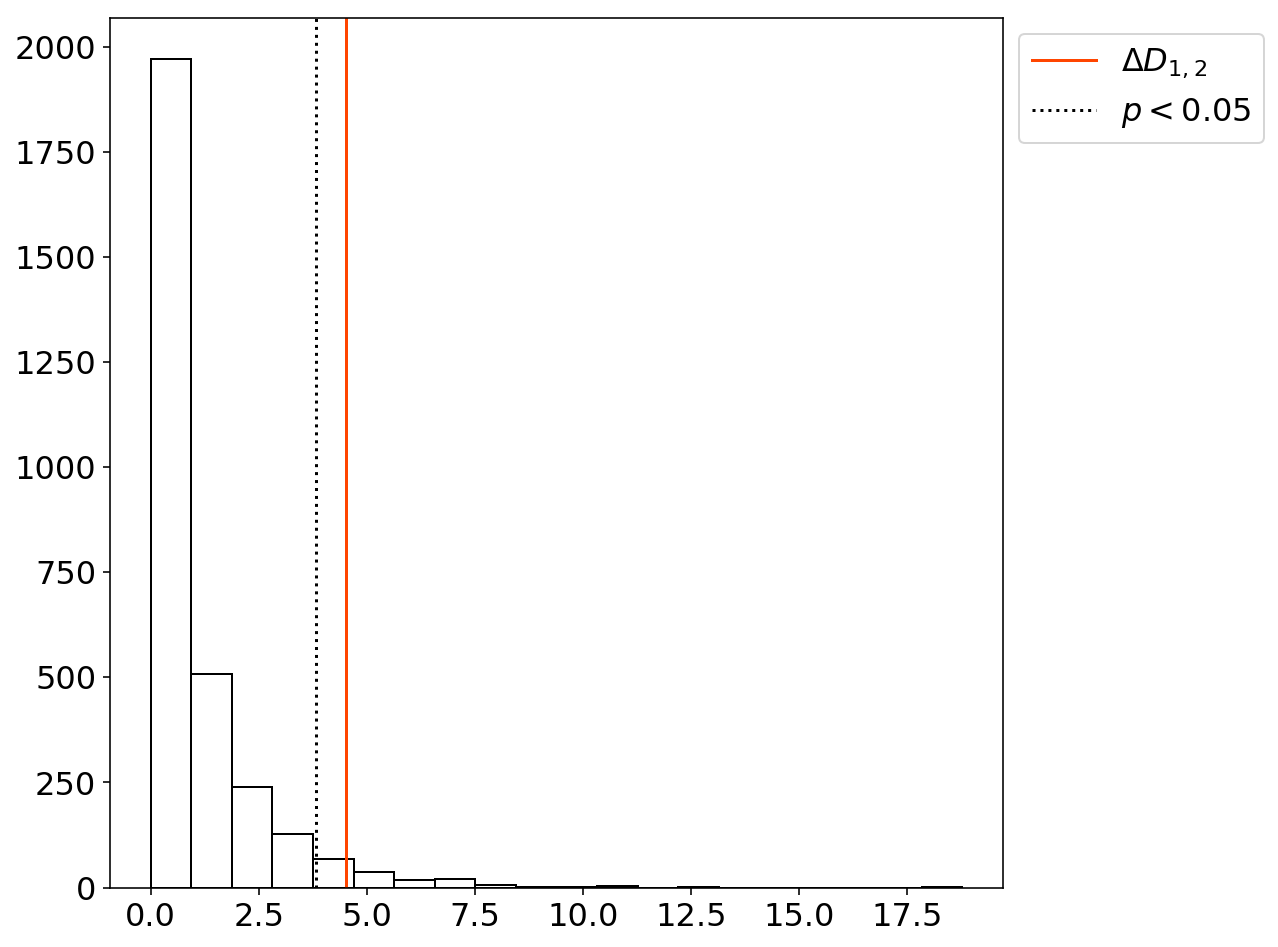

,dif_dev
count,3.000000e+03
mean,1.010958e+00
std,1.416947e+00
min,4.324962e-07
25%,1.052020e-01
50%,4.700351e-01
75%,1.359082e+00
max,1.878351e+01


p-value:
0.03266666666666666
Difference of Deviance of p < 0.05:
3.8187044560257326


In [194]:
# Set parameters
fontsize = 16
figsize = (8, 8)

rcParams['font.size'] = fontsize
rcParams['figure.figsize'] = figsize

# Generate Figure & Axes instances
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.hist(dev_dist,
        color="white",
        edgecolor="black",
        bins=20)

ax.axvline(diff_dev,
           color="orangered",
           label="$\Delta D_{1, 2}$")
ax.axvline(df_dev_dist.quantile(0.95)["dif_dev"],
           color="black",
           linestyle=":",
           label="$p < 0.05$")

# X-axis Settings
# ax.set_xlim(0, 1)
# ax.set_xlabel('X-axis')

# Y-axis Settings
# ax.set_ylim(0, 1)
# ax.set_ylabel('Y-axis')

# Legend Settings
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

df_dev_dist = pd.DataFrame(np.array(dev_dist))
df_dev_dist.columns = ["dif_dev"]
display(df_dev_dist.describe())

print("p-value:")
print(df_dev_dist[df_dev_dist["dif_dev"] >= diff_dev]["dif_dev"].count() \
      /df_dev_dist.shape[0])

print("Difference of Deviance of p < 0.05:")
print(df_dev_dist.quantile(0.95)["dif_dev"])

# $\chi^{2}$分布を使った近似計算

逸脱度の差は用いたパラメータ数の差を自由度とする$\chi^{2}$分布で近似できるとされている

In [171]:
p_val = stats.chi2.sf(x=diff_dev, df=1)
print("p-value from chi-square distribution:")
print("{:.5f}".format(p_val))
print()

print("p-value calculated by parametric bootstrapping:")
print(df_dev_dist[df_dev_dist["dif_dev"] >= diff_dev]["dif_dev"].count() \
      /df_dev_dist.shape[0])

p-value from chi-square distribution:
0.03362

p-value calculated by parametric bootstrapping:
0.03266666666666666


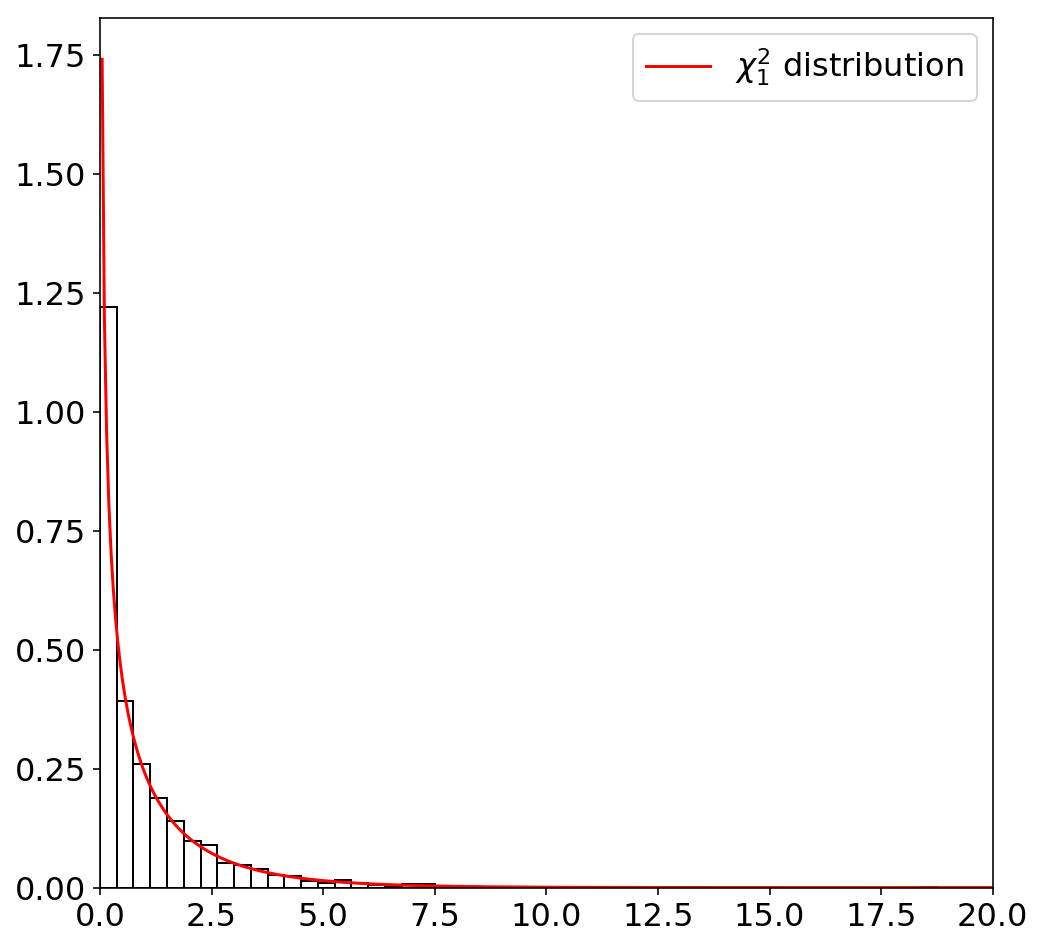

In [216]:
fontsize = 16
figsize = (8, 8)

rcParams['font.size'] = fontsize
rcParams['figure.figsize'] = figsize

# Generate Figure & Axes instances
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

bins = 50
ax.hist(dev_dist,
        color="white",
        edgecolor="black",
        bins=bins,
        density=True)

df = 1

step = 0.05
x = np.arange(step, math.ceil(df_dev_dist.max()) + 1,
              step)
trans_rate = 1
ax.plot(x,
        stats.chi2.pdf(x, df),
        'r-',
        label="$\chi_{1}^{2}$ distribution")

ax.set_xlim(0, math.ceil(df_dev_dist.max()) + 1)
ax.set_ylim(0,)

ax.legend()

plt.show()